# Notes
- This file creates 1 LightGBM model. 
- For our final submission, we created 8 models with different file chunks, random seeds, and num_boost_rounds.

# Load Libraries

In [1]:
import os

import pandas as pd
import polars as pl


import lightgbm as lgb
import matplotlib.pyplot as plt
import random
import seaborn as sns

from tqdm import tqdm

import warnings

warnings.filterwarnings('ignore')

# Logging
import logging

# Get logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
file_handler = logging.FileHandler('logs.log')

# Set log format
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Settings to display log on notebook
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

# Data Load

In [2]:
chunks_to_train_on = 20


chunk_files = [os.path.join("../trn_large_chunks/", path) for path in os.listdir("../trn_large_chunks/")] + \
                            [os.path.join("../val_large_chunks/", path) for path in os.listdir("../val_large_chunks/")]

random.seed(749812)
random_files = random.sample(chunk_files, chunks_to_train_on)
print(random_files)

trn_dfs = []
for file in tqdm(random_files):
    trn_dfs.append(pl.read_parquet(file))

trn_df = pl.concat(trn_dfs)

del trn_dfs
import gc; gc.collect()

['../trn_large_chunks/trn_df_chunk3.parquet', '../val_large_chunks/val_df_chunk0.parquet', '../trn_large_chunks/trn_df_chunk9.parquet', '../trn_large_chunks/trn_df_chunk2.parquet', '../val_large_chunks/val_df_chunk12.parquet', '../val_large_chunks/val_df_chunk9.parquet', '../trn_large_chunks/trn_df_chunk0.parquet', '../val_large_chunks/val_df_chunk1.parquet', '../val_large_chunks/val_df_chunk5.parquet', '../val_large_chunks/val_df_chunk3.parquet', '../trn_large_chunks/trn_df_chunk5.parquet', '../trn_large_chunks/trn_df_chunk1.parquet', '../val_large_chunks/val_df_chunk4.parquet', '../trn_large_chunks/trn_df_chunk7.parquet', '../trn_large_chunks/trn_df_chunk11.parquet', '../val_large_chunks/val_df_chunk2.parquet', '../val_large_chunks/val_df_chunk6.parquet', '../trn_large_chunks/trn_df_chunk4.parquet', '../trn_large_chunks/trn_df_chunk8.parquet', '../trn_large_chunks/trn_df_chunk6.parquet']


100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 52.28it/s]


0

# Train

In [3]:
target_col = 'is_clicked'
drop_cols = [
    'impression_id', 'impression_time','user_id','session_id','article_id',
]

In [4]:
#drop_colsを落としたものを特徴量として使う。pandasにする
X_train = trn_df.drop(drop_cols + [target_col]).to_pandas()
y_train = trn_df[target_col].to_pandas()

imp_train = trn_df['impression_id'].to_pandas()

logger.info(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')

X_train["category"] = X_train["category"].astype("category")

[2024-06-28 14:55:11,389][INFO] X_train shape: (56721, 436), y_train shape: (56721,)


In [5]:
# スコア計算用
from sklearn.metrics import roc_auc_score
def get_mean_auc(y_pred,y_true,impression):
    #rocをimpressionごとに計算して平均する
    pred_df = pd.DataFrame({
        'impression_id': impression,
        'y_true': y_true,
        'y_pred': y_pred
    })

    #save as valid_pred.parquet
    pred_df.to_parquet('valid_pred.parquet')

    group_auc = pred_df.groupby('impression_id').apply(lambda x: roc_auc_score(x['y_true'],x['y_pred'])).mean()

    return group_auc

In [6]:
del trn_df
import gc; gc.collect()

42

## LightGBM

In [7]:
lgb_params ={
    'boosting_type': 'gbdt',
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at':5,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'random_state': 758392,
    'n_jobs': 20,
}

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 101361
[LightGBM] [Info] Number of data points in the train set: 56721, number of used features: 436


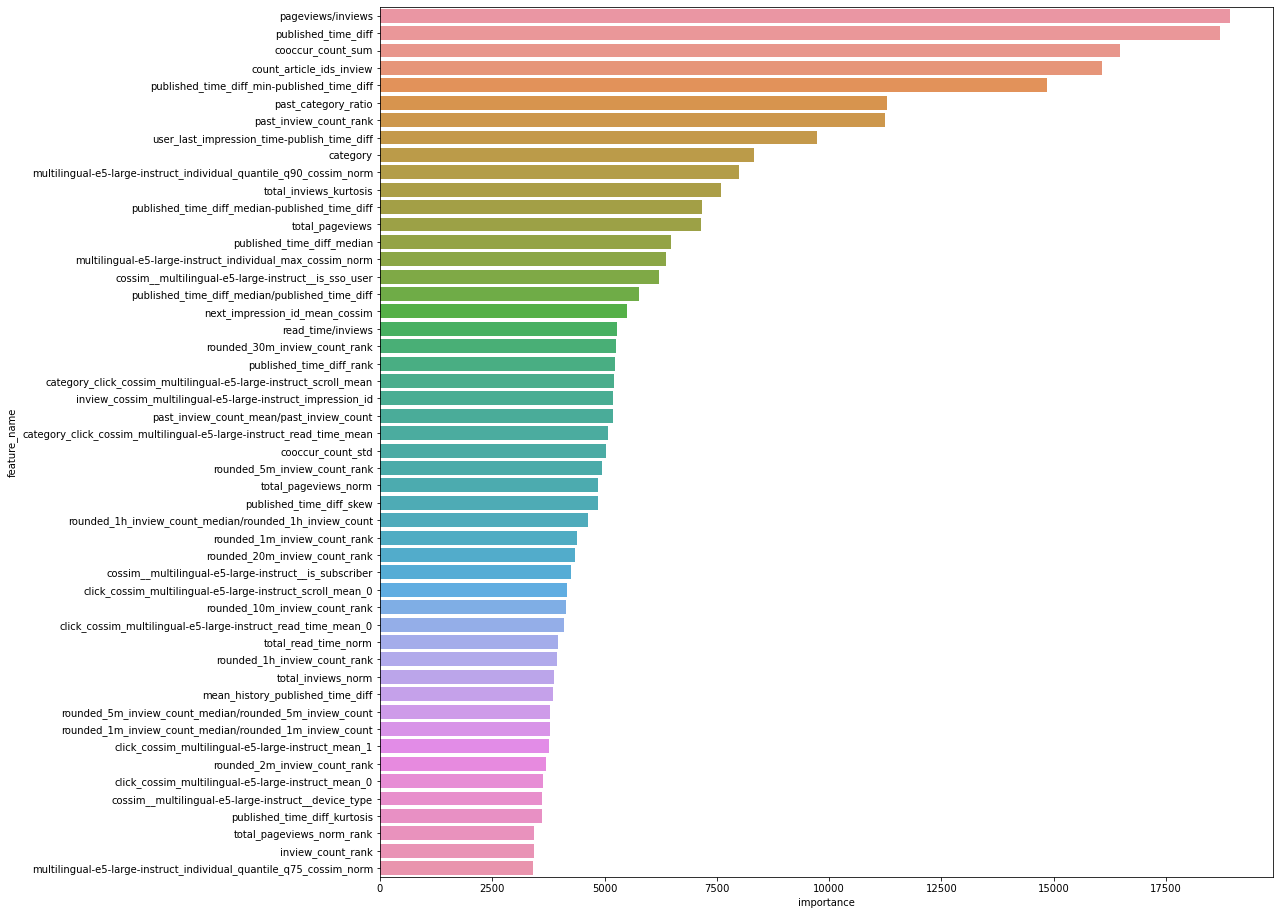

In [8]:
callbacks = [
    lgb.log_evaluation(period=100)
]

group_train = imp_train.groupby(imp_train).count().to_numpy()

lgb_train = lgb.Dataset(X_train, label=y_train,group=group_train)

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=18000,
    callbacks=callbacks
)


#feature importance
feature_importance = lgb_model.feature_importance(importance_type='gain')
feature_name = lgb_model.feature_name()

feature_importance_df = pd.DataFrame({
    'feature_name': feature_name,
    'importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

#plot
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importance_df.head(50), x='importance', y='feature_name')
plt.show()

In [9]:
lgb_model.save_model("lgb_model_20p_1.txt")